In [8]:
####################
## load libraries ##
####################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
np.random.seed(123456)

In [9]:
#################################
## sigmoid activation function ##
#################################
def sigmoid_function(theta):
    xsi = 1 / (1 + np.exp(-theta))
    return(xsi)

######################################################################
## function to manually recover feature engineered Feature Matrix X ##
## for polynomial Kernel degree 2 and c=3                           ##
######################################################################
def get_X(D, c=3):
    X = pd.DataFrame()
    X['v3_2'] = D['v3']**2
    X['v2_2'] = D['v2']**2
    X['v1_2'] = D['v1']**2
    X['v3xv2'] = np.sqrt(2)*D['v3']*D['v2']
    X['v3xv1'] = np.sqrt(2)*D['v3']*D['v1']
    X['v2xv1'] = np.sqrt(2)*D['v2']*D['v1']
    X['cv3'] = np.sqrt(2*c)*D['v3']
    X['cv2'] = np.sqrt(2*c)*D['v2']
    X['cv1'] = np.sqrt(2*c)*D['v1']
    X['c'] = c
    
    return(X)

In [10]:
###############################################################
## function to simulate OLS and Logistic Regression datasets ##
###############################################################
def simulate_dataset(n=10000, seed=123456, binary_flag=False):
    np.random.seed(123456)
    
    ## specify design matrix D
    D = pd.DataFrame()
    D['v1'] = np.random.normal(0, 1, n)
    D['v2'] = np.random.normal(0, 1, n)
    D['v3'] = np.random.normal(0, 1, n)
    
    ## split D into train and test split
    D_train, D_test = train_test_split(D, test_size=0.33, random_state=42)
    D_train = D_train.reset_index(drop=True)
    D_test = D_test.reset_index(drop=True)
    del D
    
    ## get feature matrix X for train and test
    X_train = get_X(D_train, c=3)
    X_test = get_X(D_test, c=3)
    
    ## specify beta coefficients
    beta_1 = 0.52
    beta_2 = -0.32
    beta_3 = -0.78
    beta_4 = 0.623
    beta_5 = -0.43
    beta_6 = 0.38
    beta_7 = 0.28
    beta_8 = -0.42
    beta_9 = -0.62
    beta_10 = 0.43
    
    
    if(binary_flag):
        Z_train = beta_1*X_train['v3_2'] + beta_2*X_train['v2_2'] + beta_3*X_train['v1_2'] + beta_4*X_train['v3xv2'] + beta_5*X_train['v3xv1'] + beta_6*X_train['v2xv1'] + beta_7*X_train['cv3'] + beta_8*X_train['cv2'] + beta_9*X_train['cv1'] + beta_10*X_train['c']
        Z_test = beta_1*X_test['v3_2'] + beta_2*X_test['v2_2'] + beta_3*X_test['v1_2'] + beta_4*X_test['v3xv2'] + beta_5*X_test['v3xv1'] + beta_6*X_test['v2xv1'] + beta_7*X_test['cv3'] + beta_8*X_test['cv2'] + beta_9*X_test['cv1'] + beta_10*X_test['c']
        p_train = sigmoid_function(Z_train)
        p_test = sigmoid_function(Z_test)
        X_train['Y'] = np.random.binomial(1, p_train)
        X_test['Y'] = np.random.binomial(1, p_test)
        D_train['Y'] = X_train['Y']
        D_test['Y'] = X_test['Y']
        del Z_train, Z_test, p_train, p_test
        
        model = smf.glm('Y ~ v3_2 + v2_2 + v1_2 + v3xv2 + v3xv1 + v2xv1 + cv3 + cv2 + cv1 + c -1', data=X_train, family=sm.families.Binomial()).fit()
        print(model.summary())
        
        
        
    else:
        X_train['Y'] = beta_1*X_train['v3_2'] + beta_2*X_train['v2_2'] + beta_3*X_train['v1_2'] + beta_4*X_train['v3xv2'] + beta_5*X_train['v3xv1'] + beta_6*X_train['v2xv1'] + beta_7*X_train['cv3'] + beta_8*X_train['cv2'] + beta_9*X_train['cv1'] + beta_10*X_train['c'] + np.random.normal(0, 1, X_train.shape[0])   
        X_test['Y'] = beta_1*X_test['v3_2'] + beta_2*X_test['v2_2'] + beta_3*X_test['v1_2'] + beta_4*X_test['v3xv2'] + beta_5*X_test['v3xv1'] + beta_6*X_test['v2xv1'] + beta_7*X_test['cv3'] + beta_8*X_test['cv2'] + beta_9*X_test['cv1'] + beta_10*X_test['c'] + np.random.normal(0, 1, X_test.shape[0])
        D_train['Y'] = X_train['Y']
        D_test['Y'] = X_test['Y']
        
        model = smf.ols('Y ~ v3_2 + v2_2 + v1_2 + v3xv2 + v3xv1 + v2xv1 + cv3 + cv2 + cv1 + c -1', data=X_train).fit()
        print(model.summary())
    
    
    return(D_train, D_test, X_train, X_test)

In [11]:
######################################################################
## functions to fit and predict GLMs with Feature Matrix X directly ##
######################################################################
   
def fit_GLM(df, link_function='identity'):
        
    Y = df[['Y']].copy()
    X = df.drop('Y', axis=1).copy()
    
    Beta = np.zeros(X.shape[1]).reshape((X.shape[1], 1))
    alpha = 0.0001
    
    if(link_function=='identity'):
        
        curr_loss = ((Y - np.dot(X, Beta))**2).sum()[0]
        loss_diff = 100
        while(loss_diff > 0):
            J_Beta = np.dot(X.T, (np.dot(X, Beta) - Y))
            Beta -= (alpha*J_Beta)
            new_loss = ((Y - np.dot(X, Beta))**2).sum()[0]
            loss_diff = abs(curr_loss - new_loss)
            curr_loss = new_loss
            del new_loss
    
    if(link_function=='logit'):
        p = np.array(sigmoid_function(np.dot(X, Beta)))
        p[p==1] = 0.999
        p[p==0] = 0.001
        curr_loss = np.asscalar(-np.dot(Y.T, np.log(p)) - np.dot((1-Y.T), np.log(1-p)))
        del p
        
        loss_diff = 100
        while(loss_diff > 0):
            J_Beta = np.dot(X.T, (sigmoid_function(np.dot(X, Beta)) - Y))
            Beta -= (alpha*J_Beta)
            p = np.array(sigmoid_function(np.dot(X, Beta)))
            p[p==1] = 0.999
            p[p==0] = 0.001
            new_loss = -np.dot(Y.T, np.log(p)) - np.dot((1-Y.T), np.log(1-p))
            loss_diff = abs(curr_loss - new_loss)
            curr_loss = new_loss
            del new_loss
        
    return(Beta)



def predict_GLM(Beta, df, link_function='identity'):
        
    X = df.drop('Y', axis=1)
    if(link_function=='identity'):
        df['Y_prediction'] = np.dot(X, Beta)
        plt.scatter(df['Y'], df['Y_prediction'])
        plt.title("'Standard' Linear Regression")
        plt.xlabel("Y")
        plt.ylabel("Y prediction")
        plt.show()
        
    if(link_function=='logit'):
        df['Y_prediction'] = sigmoid_function(np.dot(X, Beta))
        df.loc[df['Y_prediction']>=0.5, 'Y_prediction'] = 1
        df.loc[df['Y_prediction']<0.5, 'Y_prediction'] = 0
        print(pd.crosstab(df['Y_prediction'], df['Y']))

In [12]:
#################################################################
## functions to fit and predict GLMs with Kernelization method ##
#################################################################
def fit_Kernelized_GLM(df, X, link_function='identity'):
    
    c = 3 
    Y = df[['Y']].copy()
    D = df.drop('Y', axis=1).copy()
    K = (np.dot(D, D.T) + c) * (np.dot(D, D.T) + c)
    
    r = np.zeros(K.shape[1]).reshape((K.shape[1], 1))
    #alpha = 0.0001
    #alpha = 0.00000001
    
    if(link_function=='identity'):
        
        alpha = 0.00000001
        curr_loss = ((Y - np.dot(K, r))**2).sum()[0]
        loss_diff = 100
        while(loss_diff > 0):
            J_r = np.dot(K.T, (np.dot(K, r) - Y))
            r -= (alpha*J_r)
            new_loss = ((Y - np.dot(K, r))**2).sum()[0]
            loss_diff = abs(curr_loss - new_loss)
            curr_loss = new_loss
            del new_loss
    
        Beta = np.dot(X.T, r)
    
    if(link_function=='logit'):
        alpha = 0.0000001
        p = np.array(sigmoid_function(np.dot(K, r)))
        p[p==1] = 0.999
        p[p==0] = 0.001
        curr_loss = np.asscalar(-np.dot(Y.T, np.log(p)) - np.dot((1-Y.T), np.log(1-p)))
        del p
        
        loss_diff = 100
        while(loss_diff > 0):
            J_Beta = np.dot(K.T, (sigmoid_function(np.dot(K, r)) - Y))
            r -= (alpha*J_Beta)
            p = np.array(sigmoid_function(np.dot(K, r)))
            p[p==1] = 0.999
            p[p==0] = 0.001
            new_loss = np.asscalar(-np.dot(Y.T, np.log(p)) - np.dot((1-Y.T), np.log(1-p)))
            loss_diff = abs(curr_loss - new_loss)
            curr_loss = new_loss
            del new_loss
        
        Beta = np.dot(X.T, r)
        
    return(Beta, r)
    
    
def predict_GLM_kernelized(r, D_train, D_test, link_function='identity'):
    
    c = 3 
    df = D_test.copy()
    D_train = D_train.drop('Y', axis=1).copy()
    D_test = D_test.drop('Y', axis=1).copy()
    K = (np.dot(D_test, D_train.T) + c) * (np.dot(D_test, D_train.T) + c)
    
    if(link_function=='identity'):
        df['Y_prediction'] = np.dot(K, r)
        plt.scatter(df['Y'], df['Y_prediction'])
        plt.title("'Kernelized' Linear Regression")
        plt.xlabel("Y")
        plt.ylabel("Y prediction")
        plt.show()
    
    if(link_function=='logit'):
        df['Y_prediction'] = sigmoid_function(np.dot(K, r))
        df.loc[df['Y_prediction']>=0.5, 'Y_prediction'] = 1
        df.loc[df['Y_prediction']<0.5, 'Y_prediction'] = 0
        print(pd.crosstab(df['Y_prediction'], df['Y']))

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     532.9
Date:                Sun, 19 Sep 2021   Prob (F-statistic):          6.91e-296
Time:                        23:23:31   Log-Likelihood:                -957.25
No. Observations:                 670   AIC:                             1935.
Df Residuals:                     660   BIC:                             1980.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v3_2           0.5262      0.030     17.505      0.0

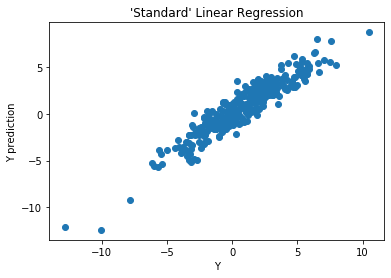

In [13]:
#######################
## Linear Regression ##
#######################
## Feature Matrix X approach:
D_train, D_test, X_train, X_test = simulate_dataset(n=1000, seed=123456, binary_flag=False)
Beta_standard = fit_GLM(df=X_train, link_function='identity')
predict_GLM(Beta=Beta_standard, df=X_test, link_function='identity')

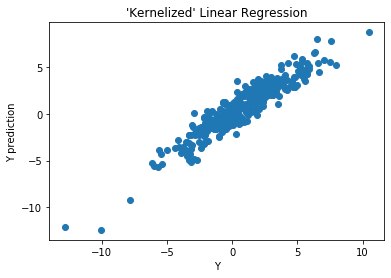

In [14]:
#######################
## Linear Regression ##
#######################
## Kernelization approach:
Beta_kernelized, r = fit_Kernelized_GLM(df=D_train, X=X_train.drop('Y', axis=1), link_function='identity')
predict_GLM_kernelized(r=r, D_train=D_train, D_test=D_test, link_function='identity')

In [15]:
#########################
## Logistic Regression ##
#########################
## Feature Matrix X approach:
D_train, D_test, X_train, X_test = simulate_dataset(n=1000, seed=123456, binary_flag=True)
Beta_standard = fit_GLM(df=X_train, link_function='logit')
predict_GLM(Beta=Beta_standard, df=X_test, link_function='logit')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                  670
Model:                            GLM   Df Residuals:                      660
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -283.30
Date:                Sun, 19 Sep 2021   Deviance:                       566.59
Time:                        23:24:04   Pearson chi2:                     662.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
v3_2           0.3634      0.102      3.570      0.0

In [16]:
#########################
## Logistic Regression ##
#########################
## Kernelization approach:
Beta_kernelized, r = fit_Kernelized_GLM(df=D_train, X=X_train.drop('Y', axis=1), link_function='logit')
predict_GLM_kernelized(r=r, D_train=D_train, D_test=D_test, link_function='logit') 

Y               0    1
Y_prediction          
0.0           105   19
1.0            27  179
